In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import folium
from folium.plugins import MarkerCluster

In [ ]:
df = pd.read_csv('data_20221_cleaned.csv')

In [ ]:
print("Original Dataset preview: ")
print(df.head())
print(f"Dataset shape: {df.shape}")

Original Dataset preview: 
            Well ID  S.No        STATE       DISTRICT  ...     F SiO2     TDS U(ppb)
0  W113126092431802   1.0  A&N Islands  South Andaman  ...  0.84  NaN   206.0    4.8
1  W113616092411001   2.0  A&N Islands  South Andaman  ...  0.28  NaN   381.0    6.4
2  W113640092443301   3.0  A&N Islands  South Andaman  ...  0.46  NaN   151.0    BDL
3  W114421092422801   4.0  A&N Islands  South Andaman  ...  0.37  NaN   198.0    0.4
4  W113955092391801   5.0  A&N Islands  South Andaman  ...  0.95  NaN  1424.0    BDL

[5 rows x 26 columns]
Dataset shape: (8234, 26)


In [ ]:
#Instead of dropping location data, we'll keep it for well prediction
columns_drop = ['S.No', 'PO4', 'SiO2', 'U(ppb)', 'Year']
df.drop(columns=columns_drop, inplace=True)

In [ ]:
#Separate categorical and numerical columns
categorical_columns = ['Well ID', 'STATE', 'DISTRICT', 'BLOCK', 'LOCATION']
numerical_columns = df.columns.difference(categorical_columns + ['LATITUDE', 'LONGITUDE', 'Year'])

In [ ]:
# numerical columns to numeric
for col in numerical_columns:
  df[col] = pd.to_numeric(df[col], errors='coerce')

In [ ]:
df['LATITUDE'] = pd.to_numeric(df['LATITUDE'], errors='coerce')
df['LONGITUDE'] = pd.to_numeric(df['LONGITUDE'], errors='coerce')

In [ ]:
df.head(5)

,Well ID,STATE,DISTRICT,BLOCK,LOCATION,LATITUDE,LONGITUDE,pH,EC,CO3,HCO3,Cl,SO4,NO3,TH,Ca,Mg,Na,K,F,TDS
0,W113126092431802,A&N Islands,South Andaman,PORT BLAIR,Kodiaghat,11.54500,92.74583,7.74,349.0,0.0,183.0,25.0,1.0,1.0,175.0,34.0,22.0,10.0,0.0,0.84,206.0
1,W113616092411001,A&N Islands,South Andaman,PORT BLAIR,Sippighat,11.60250,92.73000,7.53,660.0,0.0,262.0,82.0,5.0,1.0,250.0,52.0,29.0,51.0,1.0,0.28,381.0
2,W113640092443301,A&N Islands,South Andaman,PORT BLAIR,Brichganj,11.62083,92.73028,7.50,270.0,0.0,116.0,35.0,1.0,0.0,125.0,4.0,28.0,10.0,1.0,0.46,151.0
3,W114421092422801,A&N Islands,South Andaman,FERRARGUNJ,Wimberleyganj,11.73250,92.70861,7.60,311.0,0.0,159.0,39.0,2.0,0.0,135.0,26.0,17.0,15.0,2.0,0.37,198.0
4,W113955092391801,A&N Islands,South Andaman,FERRARGUNJ,Ograbraj,11.66361,92.65806,7.82,2501.0,0.0,512.0,560.0,56.0,5.0,465.0,56.0,79.0,336.0,18.0,0.95,1424.0


In [ ]:
# Fill missing values with median for numerical data
for col in numerical_columns:
  df[col].fillna(df[col].median(), inplace=True)

<ipython-input-124-d5fa02e9f21e>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [ ]:
df.head(3)

,Well ID,STATE,DISTRICT,BLOCK,LOCATION,LATITUDE,LONGITUDE,pH,EC,CO3,HCO3,Cl,SO4,NO3,TH,Ca,Mg,Na,K,F,TDS
0,W113126092431802,A&N Islands,South Andaman,PORT BLAIR,Kodiaghat,11.54500,92.74583,7.74,349.0,0.0,183.0,25.0,1.0,1.0,175.0,34.0,22.0,10.0,0.0,0.84,206.0
1,W113616092411001,A&N Islands,South Andaman,PORT BLAIR,Sippighat,11.60250,92.73000,7.53,660.0,0.0,262.0,82.0,5.0,1.0,250.0,52.0,29.0,51.0,1.0,0.28,381.0
2,W113640092443301,A&N Islands,South Andaman,PORT BLAIR,Brichganj,11.62083,92.73028,7.50,270.0,0.0,116.0,35.0,1.0,0.0,125.0,4.0,28.0,10.0,1.0,0.46,151.0


In [ ]:
# Fill missing values for coordinates with mean if present
if df['LATITUDE'].notna().any() and df['LONGITUDE'].notna().any():
  df['LATITUDE'].fillna(df['LATITUDE'].mean(), inplace=True)
  df['LONGITUDE'].fillna(df['LONGITUDE'].mean(), inplace=True)

<ipython-input-126-1d49f1572394>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['LATITUDE'].fillna(df['LATITUDE'].mean(), inplace=True)
<ipython-input-126-1d49f1572394>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

In [ ]:
df.head(5)

,Well ID,STATE,DISTRICT,BLOCK,LOCATION,LATITUDE,LONGITUDE,pH,EC,CO3,HCO3,Cl,SO4,NO3,TH,Ca,Mg,Na,K,F,TDS
0,W113126092431802,A&N Islands,South Andaman,PORT BLAIR,Kodiaghat,11.54500,92.74583,7.74,349.0,0.0,183.0,25.0,1.0,1.0,175.0,34.0,22.0,10.0,0.0,0.84,206.0
1,W113616092411001,A&N Islands,South Andaman,PORT BLAIR,Sippighat,11.60250,92.73000,7.53,660.0,0.0,262.0,82.0,5.0,1.0,250.0,52.0,29.0,51.0,1.0,0.28,381.0
2,W113640092443301,A&N Islands,South Andaman,PORT BLAIR,Brichganj,11.62083,92.73028,7.50,270.0,0.0,116.0,35.0,1.0,0.0,125.0,4.0,28.0,10.0,1.0,0.46,151.0
3,W114421092422801,A&N Islands,South Andaman,FERRARGUNJ,Wimberleyganj,11.73250,92.70861,7.60,311.0,0.0,159.0,39.0,2.0,0.0,135.0,26.0,17.0,15.0,2.0,0.37,198.0
4,W113955092391801,A&N Islands,South Andaman,FERRARGUNJ,Ograbraj,11.66361,92.65806,7.82,2501.0,0.0,512.0,560.0,56.0,5.0,465.0,56.0,79.0,336.0,18.0,0.95,1424.0


In [ ]:
# Water Quality classification (feature) based on some thresholds
conditions = [
    (df['pH'] >= 6.5) & (df['pH'] <= 8.5) &
    (df['EC'] <= 1500) &
    (df['TH'] <= 120) &
    (df['NO3'] <= 10) &
    (df['Na'] <= 200) &
    (df['K'] <= 10) &
    (df['F'] <= 1.5),

    (df['pH'] < 6.5) | (df['pH'] > 8.5) |
    (df['EC'] > 1500) |
    (df['TH'] > 120) |
    (df['NO3'] > 10) |
    (df['Na'] > 200) |
    (df['K'] > 10) |
    (df['F'] > 1.5)
]
choices = ['Good', 'Poor']
df['Water_Quality'] = np.select(conditions, choices, default='Moderate')

In [ ]:
# New Target Variables for Well Prediction
# 1. Well Yield Prediction
df['Well_Yield'] = np.where(
    (df['EC'] < 1000) & (df['TH'] < 100) & (df['NO3'] < 8), 'High',
    np.where((df['EC'] > 2000) | (df['TH'] > 150) | (df['NO3'] > 15), 'Low', 'Medium')
)

In [ ]:
# 2. Well Suitability for different uses
df['Well_Suitability'] = np.where(
    (df['pH'] >= 6.5) & (df['pH'] <= 8.5) & (df['F'] <= 1.0) & (df['NO3'] <= 5), 'Drinking',
    np.where((df['EC'] <= 2000) & (df['Na'] <= 150), 'Agriculture', 'Industrial')
)

In [ ]:
# 3. Maintenance for different uses
df['Maintenance_Needed'] = np.where(
    (df['pH'] < 6.0) | (df['pH'] > 9.0) | (df['EC'] > 2500), 'Soon',
    np.where(
        (df['pH'] < 6.2) | (df['pH'] > 8.8) | (df['EC'] > 2000), 'Medium-term', 'Long-term'
    )
)

In [ ]:
print("\nDataset after feature engineering: ")
print(df[['Well_Yield', 'Well_Suitability', 'Water_Quality', 'Maintenance_Needed']].head())


Dataset after feature engineering: 
  Well_Yield Well_Suitability Water_Quality Maintenance_Needed
0        Low         Drinking          Poor          Long-term
1        Low         Drinking          Poor          Long-term
2     Medium         Drinking          Poor          Long-term
3     Medium         Drinking          Poor          Long-term
4        Low         Drinking          Poor               Soon


In [ ]:
# Encode categorical features
label_encoders = {}
for col in ['STATE', 'DISTRICT', 'BLOCK', 'LOCATION']:
  if col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [ ]:
# Encode target variables
target_encoders = {}
for col in ['Water_Quality', 'Well_Yield', 'Well_Suitability', 'Maintenance_Needed']:
  le = LabelEncoder()
  df[col] = le.fit_transform(df[col])
  target_encoders[col] = le
  print(f"{col} classes: {list(le.classes_)}")

Water_Quality classes: ['Good', 'Poor']
Well_Yield classes: ['High', 'Low', 'Medium']
Well_Suitability classes: ['Agriculture', 'Drinking', 'Industrial']
Maintenance_Needed classes: ['Long-term', 'Medium-term', 'Soon']


In [ ]:
df.head(5)

,Well ID,STATE,DISTRICT,BLOCK,LOCATION,LATITUDE,LONGITUDE,pH,EC,CO3,HCO3,Cl,SO4,NO3,TH,Ca,Mg,Na,K,F,TDS,Water_Quality,Well_Yield,Well_Suitability,Maintenance_Needed
0,W113126092431802,0,420,2153,3735,11.54500,92.74583,7.74,349.0,0.0,183.0,25.0,1.0,1.0,175.0,34.0,22.0,10.0,0.0,0.84,206.0,1,1,1,0
1,W113616092411001,0,420,2153,6486,11.60250,92.73000,7.53,660.0,0.0,262.0,82.0,5.0,1.0,250.0,52.0,29.0,51.0,1.0,0.28,381.0,1,1,1,0
2,W113640092443301,0,420,2153,1232,11.62083,92.73028,7.50,270.0,0.0,116.0,35.0,1.0,0.0,125.0,4.0,28.0,10.0,1.0,0.46,151.0,1,2,1,0
3,W114421092422801,0,420,886,7173,11.73250,92.70861,7.60,311.0,0.0,159.0,39.0,2.0,0.0,135.0,26.0,17.0,15.0,2.0,0.37,198.0,1,2,1,0
4,W113955092391801,0,420,886,5100,11.66361,92.65806,7.82,2501.0,0.0,512.0,560.0,56.0,5.0,465.0,56.0,79.0,336.0,18.0,0.95,1424.0,1,1,1,2


In [ ]:
# Prepare features and targets
feature_columns = [col for col in df.columns if col not in ['Well ID', 'Water_Quality', 'Well_Yield', 'Well_Suitability', 'Maintenance_Needed']]
X = df[feature_columns]
y_quality = df['Water_Quality']
y_yield = df['Well_Yield']
y_suitability = df['Well_Suitability']
y_maintenance = df['Maintenance_Needed']

In [ ]:
# Feature Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Save feature list, scaler and encoders for use in prediction
joblib.dump(feature_columns, 'feature_columns.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(target_encoders, 'target_encoders.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']

In [ ]:
# Data split
X_train, X_test, y_quality_train, y_quality_test, y_yield_train, y_yield_test, y_suitability_train, y_suitability_test, y_maintenance_train, y_maintenance_test = train_test_split(
    X_scaled,
    y_quality,
    y_yield,
    y_suitability,
    y_maintenance,
    test_size=0.2,
    random_state=42
)

In [ ]:
# Covert to categorical
y_quality_train_cat = to_categorical(y_quality_train)
y_quality_test_cat = to_categorical(y_quality_test)
y_yield_train_cat = to_categorical(y_yield_train)
y_yield_test_cat = to_categorical(y_yield_test)
y_suitability_train_cat = to_categorical(y_suitability_train)
y_suitability_test_cat = to_categorical(y_suitability_test)
y_maintenance_train_cat = to_categorical(y_maintenance_train)
y_maintenance_test_cat = to_categorical(y_maintenance_test)

In [ ]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [ ]:
# Neural Network with Multiple Outputs
# Model with shared layers and multiple outputs
input_layer = Input(shape=(X_train.shape[1],))
shared_layer = Dense(128, activation='relu')(input_layer)
shared_layer = Dropout(0.3)(shared_layer)
shared_layer = Dense(64, activation='relu')(shared_layer)
shared_layer = Dropout(0.2)(shared_layer)

In [ ]:
# Output layers for each prediction task
quality_output = Dense(len(np.unique(y_quality)), activation='softmax', name='quality_output')(shared_layer)
yield_output = Dense(len(np.unique(y_yield)), activation='softmax', name='yield_output')(shared_layer)
suitability_output = Dense(len(np.unique(y_suitability)), activation='softmax', name='suitability_output')(shared_layer)
maintenance_output = Dense(len(np.unique(y_maintenance)), activation='softmax', name='maintenance_output')(shared_layer)

In [ ]:
# Model creation
model = Model(
    inputs=input_layer,
    outputs=[quality_output, yield_output, suitability_output, maintenance_output]
)

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss={
        'quality_output': 'categorical_crossentropy',
        'yield_output': 'categorical_crossentropy',
        'suitability_output': 'categorical_crossentropy',
        'maintenance_output': 'categorical_crossentropy'
    },
    metrics={
        'quality_output': 'accuracy',
        'yield_output': 'accuracy',
        'suitability_output': 'accuracy',
        'maintenance_output': 'accuracy'
    }
)

In [ ]:
# Model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │      2,688 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ quality_output      │ (None, 2)         │        130 │ dropout_5[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ yield_output        │ (None, 3)         │        195 │ dropout_5[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ suitability_output  │ (None, 3)         │        195 │ dropout_5[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maintenance_output  │ (None, 3)         │        195 │ dropout_5[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,659 (45.54 KB)

 Trainable params: 11,659 (45.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    X_train,
    {
        'quality_output': y_quality_train_cat,
        'yield_output': y_yield_train_cat,
        'suitability_output': y_suitability_train_cat,
        'maintenance_output': y_maintenance_train_cat
    },
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.6712 - maintenance_output_accuracy: 0.7573 - maintenance_output_loss: 0.6631 - quality_output_accuracy: 0.8335 - quality_output_loss: 0.4064 - suitability_output_accuracy: 0.5962 - suitability_output_loss: 0.9174 - yield_output_accuracy: 0.7767 - yield_output_loss: 0.6843 - val_loss: 1.3568 - val_maintenance_output_accuracy: 0.9302 - val_maintenance_output_loss: 0.2267 - val_quality_output_accuracy: 0.9226 - val_quality_output_loss: 0.1888 - val_suitability_output_accuracy: 0.7731 - val_suitability_output_loss: 0.5319 - val_yield_output_accuracy: 0.8263 - val_yield_output_loss: 0.4122
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4357 - maintenance_output_accuracy: 0.9234 - maintenance_output_loss: 0.2406 - quality_output_accuracy: 0.9256 - quality_output_loss: 0.1772 - suitability_output_accuracy: 0.7320 - suitability_output_loss: 0.5964 - yield_output_accuracy: 0.8210 - yield_output_loss: 0.4214 - val_loss:

In [ ]:
# Model Evaluation
evaluation = model.evaluate(
    X_test,
    {
        'quality_output': y_quality_test_cat,
        'yield_output': y_yield_test_cat,
        'suitability_output': y_suitability_test_cat,
        'maintenance_output': y_maintenance_test_cat
    },
    verbose=0
)

In [ ]:
print("\nNeural Network Evaluation: ")
print(f"Overall Loss: {evaluation[0]:.4f}")
print(f"Water Quality Accuracy: {evaluation[5]:.4f}")
print(f"Well Yield Accuracy: {evaluation[6]:.4f}")
print(f"Well Suitability Accuracy: {evaluation[7]:.4f}")
print(f"Maintenance Needs Accuracy: {evaluation[8]:.4f}")


Neural Network Evaluation: 
Overall Loss: 0.3503
Water Quality Accuracy: 0.9666
Well Yield Accuracy: 0.9879
Well Suitability Accuracy: 0.9387
Maintenance Needs Accuracy: 0.9727


In [ ]:
model.save('well_predictor_model.h5')

In [ ]:
# Make predictions
predictions = model.predict(X_test)
quality_prediction = np.argmax(predictions[0], axis=1)
yield_prediction = np.argmax(predictions[1], axis=1)
suitability_prediction = np.argmax(predictions[2], axis=1)
maintenance_prediction = np.argmax(predictions[3], axis=1)

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
# Classification Reports
print("\nClassification Report for Water Quality: ")
print(classification_report(
    y_quality_test,
    quality_prediction,
    target_names=target_encoders['Water_Quality'].classes_
))


Classification Report for Water Quality: 
              precision    recall  f1-score   support

        Good       0.89      0.97      0.93       128
        Poor       1.00      0.99      0.99      1519

    accuracy                           0.99      1647
   macro avg       0.94      0.98      0.96      1647
weighted avg       0.99      0.99      0.99      1647



In [ ]:
print('\nClassification Report for Well Yield: ')
print(classification_report(
    y_yield_test,
    yield_prediction,
    target_names=target_encoders['Well_Yield'].classes_
))


Classification Report for Well Yield: 
              precision    recall  f1-score   support

        High       0.90      0.95      0.92       127
         Low       0.99      0.99      0.99      1341
      Medium       0.87      0.88      0.87       179

    accuracy                           0.97      1647
   macro avg       0.92      0.94      0.93      1647
weighted avg       0.97      0.97      0.97      1647



In [ ]:
print("\nClassification Report for Well Suitability: ")
print(classification_report(
    y_suitability_test,
    suitability_prediction,
    target_names=target_encoders['Well_Suitability'].classes_
))


Classification Report for Well Suitability: 
              precision    recall  f1-score   support

 Agriculture       0.97      0.94      0.96       969
    Drinking       0.85      0.91      0.88       376
  Industrial       0.95      0.96      0.96       302

    accuracy                           0.94      1647
   macro avg       0.92      0.94      0.93      1647
weighted avg       0.94      0.94      0.94      1647



In [ ]:
print("\nClassification Report for Maintenance Needs: ")
print(classification_report(
    y_maintenance_test,
    maintenance_prediction,
    target_names=target_encoders['Maintenance_Needed'].classes_
))


Classification Report for Maintenance Needs: 
              precision    recall  f1-score   support

   Long-term       0.97      1.00      0.98      1305
 Medium-term       0.82      0.58      0.68        92
        Soon       0.98      0.96      0.97       250

    accuracy                           0.97      1647
   macro avg       0.92      0.84      0.88      1647
weighted avg       0.96      0.97      0.96      1647



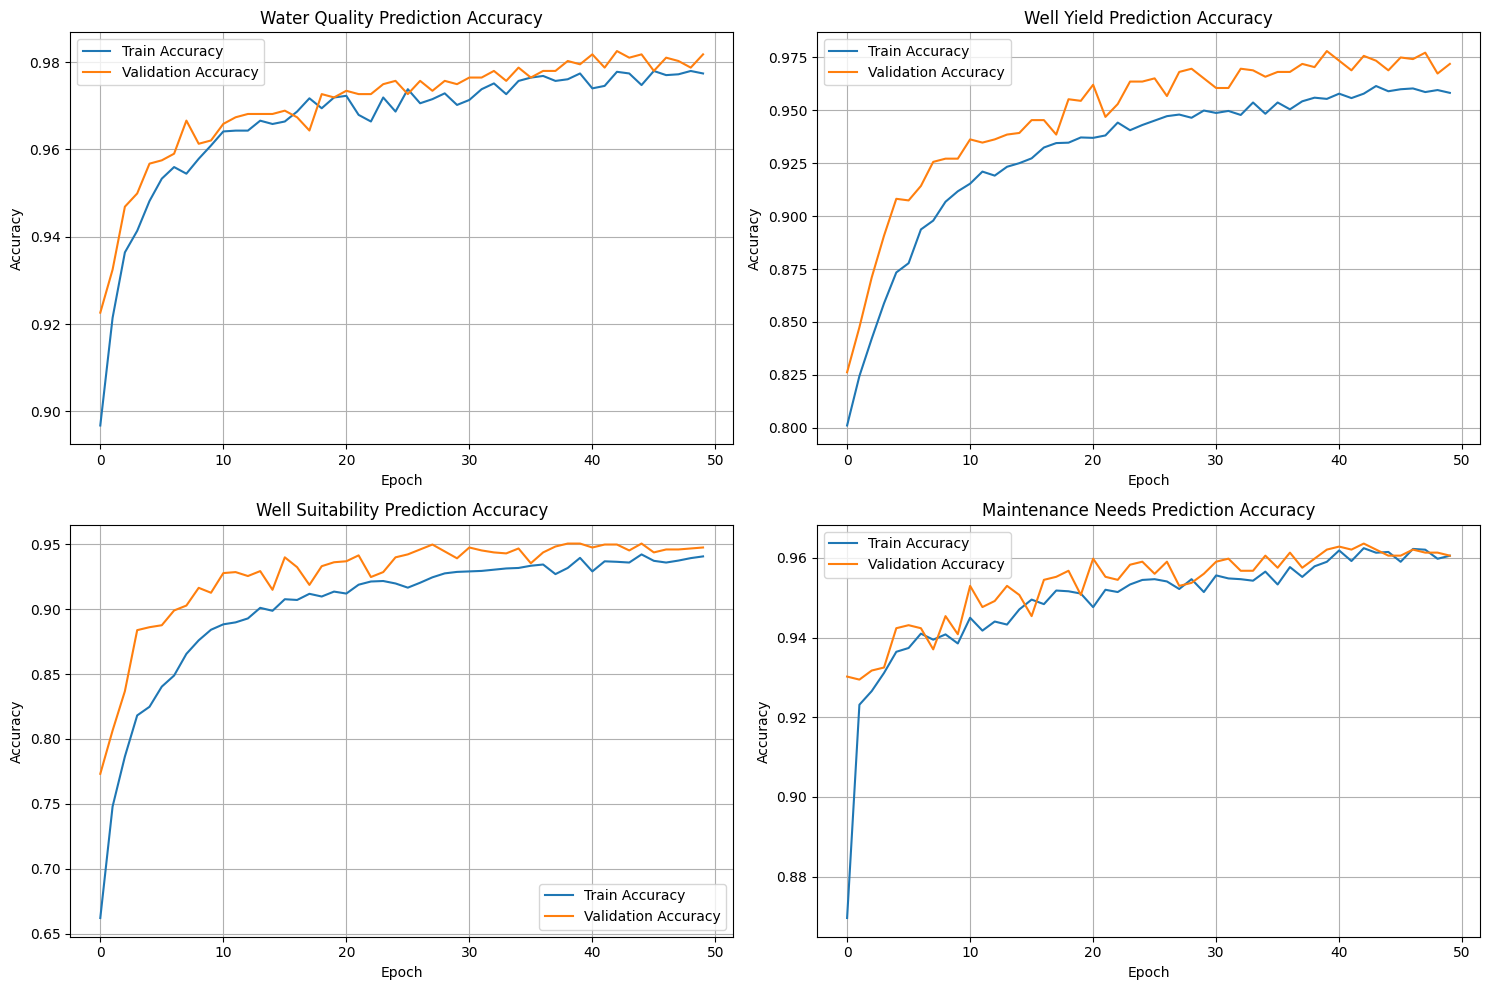

In [ ]:
# Plot training history
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['quality_output_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_quality_output_accuracy'], label='Validation Accuracy')
plt.title('Water Quality Prediction Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(history.history['yield_output_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_yield_output_accuracy'], label='Validation Accuracy')
plt.title('Well Yield Prediction Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(history.history['suitability_output_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_suitability_output_accuracy'], label='Validation Accuracy')
plt.title('Well Suitability Prediction Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(history.history['maintenance_output_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_maintenance_output_accuracy'], label='Validation Accuracy')
plt.title('Maintenance Needs Prediction Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# **Tabnet Implementation**

In [ ]:
pip install pytorch-tabnet

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

In [ ]:
# Dictionary to store models and results
tabnet_models = {}
predictions = {}

In [ ]:
# Defining target columns and respective encoders
target_columns = ['Water_Quality', 'Well_Yield', 'Well_Suitability', 'Maintenance_Needed']
X_data = X_scaled

In [ ]:
X_data

array([[-2.24618285,  1.2931399 ,  0.62053366, ..., -0.29939258,
        -0.07857594, -0.52856161],
       [-2.24618285,  1.2931399 ,  0.62053366, ..., -0.28074155,
        -0.14627672, -0.30656867],
       [-2.24618285,  1.2931399 ,  0.62053366, ..., -0.28074155,
        -0.12451575, -0.59833082],
       ...,
       [ 1.55303935,  1.28582517,  1.05445825, ..., -0.21359784,
        -0.18012711, -0.1606876 ],
       [ 1.55303935,  1.28582517,  1.29909431, ..., -0.20240722,
        -0.1656198 , -0.31037427],
       [ 1.55303935,  1.28582517,  1.29909431, ..., -0.19867701,
        -0.16320192, -0.06427924]])

In [ ]:
def plot_classification_report(y_true, y_pred, target_names, title="Classification Report"):
    report_dict = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    df = pd.DataFrame(report_dict).transpose()

    # Only keeping relevant classes (filter out 'accuracy', 'macro avg', etc. if needed)
    df = df.iloc[:-3, :]

    plt.figure(figsize=(8, 5))
    sns.heatmap(df.iloc[:, :-1], annot=True, cmap="Blues", fmt=".2f")
    plt.title(title)
    plt.ylabel("Classes")
    plt.xlabel("Metrics")
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_').lower()}.png")
    plt.show()


 Training TabNet for: Water_Quality

Early stopping occurred at epoch 35 with best_epoch = 25 and best_test_accuracy = 0.98118


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Classification Report for Water_Quality: 
              precision    recall  f1-score   support

        Good       0.83      0.95      0.89       128
        Poor       1.00      0.98      0.99      1519

    accuracy                           0.98      1647
   macro avg       0.91      0.96      0.94      1647
weighted avg       0.98      0.98      0.98      1647



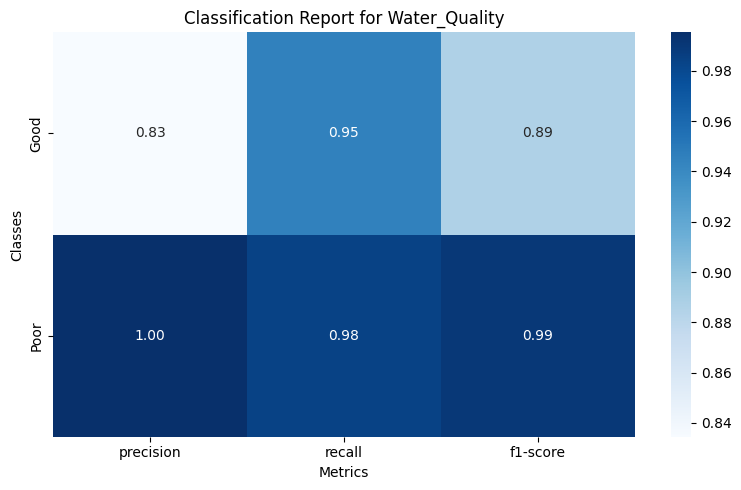


 Training TabNet for: Well_Yield

Early stopping occurred at epoch 26 with best_epoch = 16 and best_test_accuracy = 0.96175


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Classification Report for Well_Yield: 
              precision    recall  f1-score   support

        High       0.99      0.78      0.87       127
         Low       0.99      0.98      0.99      1341
      Medium       0.77      0.93      0.84       179

    accuracy                           0.96      1647
   macro avg       0.92      0.90      0.90      1647
weighted avg       0.97      0.96      0.96      1647



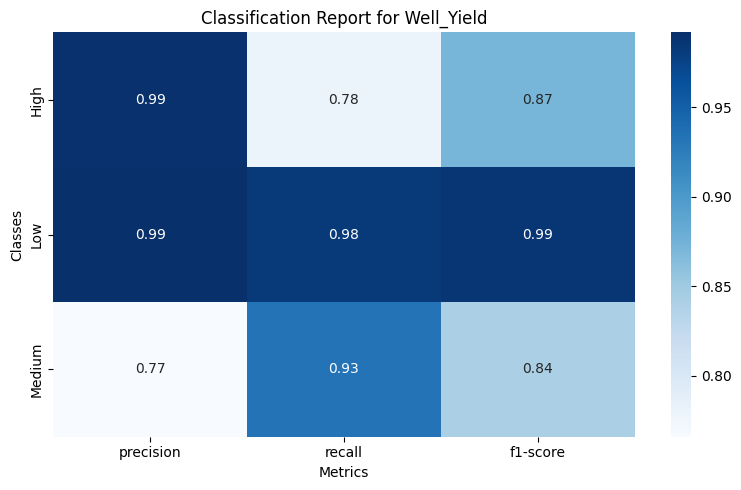


 Training TabNet for: Well_Suitability

Early stopping occurred at epoch 26 with best_epoch = 16 and best_test_accuracy = 0.91439


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Classification Report for Well_Suitability: 
              precision    recall  f1-score   support

 Agriculture       0.95      0.93      0.94       969
    Drinking       0.83      0.89      0.85       376
  Industrial       0.92      0.90      0.91       302

    accuracy                           0.91      1647
   macro avg       0.90      0.90      0.90      1647
weighted avg       0.92      0.91      0.92      1647



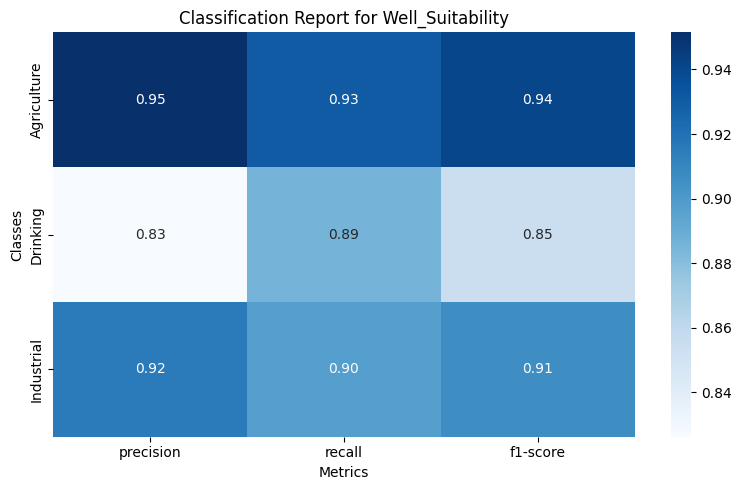


 Training TabNet for: Maintenance_Needed

Early stopping occurred at epoch 20 with best_epoch = 10 and best_test_accuracy = 0.96053


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Classification Report for Maintenance_Needed: 
              precision    recall  f1-score   support

   Long-term       0.96      1.00      0.98      1305
 Medium-term       0.85      0.45      0.59        92
        Soon       0.97      0.96      0.96       250

    accuracy                           0.96      1647
   macro avg       0.93      0.80      0.84      1647
weighted avg       0.96      0.96      0.96      1647



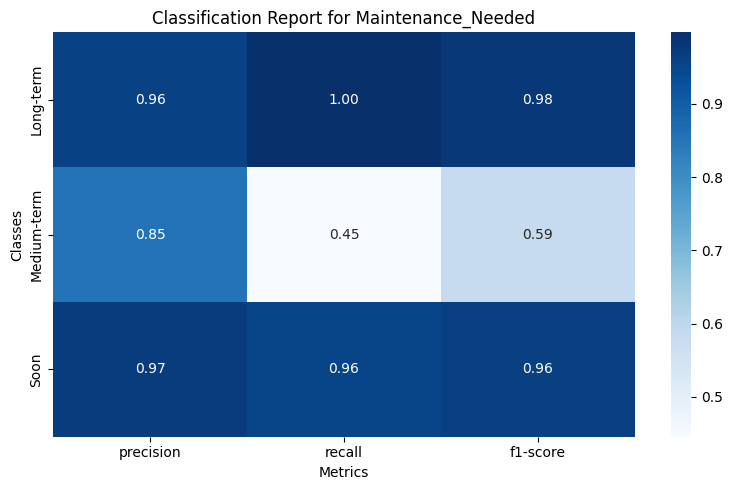

In [ ]:
for target in target_columns:
  print(f"\n Training TabNet for: {target}")

  # Data Prepare
  y_data = df[target].values

  X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

  # Model Initialization
  clf = TabNetClassifier(
      optimizer_fn=torch.optim.Adam,
      optimizer_params=dict(lr=2e-2),
      scheduler_params={"step_size": 10, "gamma": 0.9},
      scheduler_fn=torch.optim.lr_scheduler.StepLR,
      verbose=0,
  )

  # Model train
  clf.fit(
      X_train, y_train,
      eval_set=[(X_test, y_test)],
      eval_name=['test'],
      eval_metric=['accuracy'],
      max_epochs=100,
      patience=10,
      batch_size=512,
      virtual_batch_size=128,
      num_workers=0,
  )

  # Model save and predictions
  tabnet_models[target] = clf
  preds = clf.predict(X_test)
  predictions[target] = {
      "y_true": y_test,
      "y_pred": preds,
  }

  # Generating Classification Reports
  print(f"\nClassification Report for {target}: ")
  print(classification_report(
      y_test,
      preds,
      target_names=target_encoders[target].classes_
  ))

  plot_classification_report(
    y_test,
    preds,
    target_names=target_encoders[target].classes_,
    title=f"Classification Report for {target}"
  )